In [1]:
from glob import glob
import json
import os
from pathlib import Path
import pickle
import sys
import time

from matplotlib import animation
from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import mplcursors
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_events_wdict, find_nearest_ind

In [5]:
%matplotlib widget

# Load experiment

In [6]:
data_dir = Path(r"P:\\")
plotsavedir = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\analysis\THstim_project\THactivation")
subject_csv = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\CL-CM stim\subject_metadata.csv")
all_subexp = pd.read_csv(subject_csv)
all_subexp.head()

,mouse,sex,DOB,strain,exp_folder,histology,EEG,stim_tip_distance,tiparea,dist_CL,color
0,mouse771424,F,NaN,C57BL/6J,THstim_d1_2024-11-14_11-28-16,True,False,300,TH,0.925338,tomato
1,mouse771424,F,NaN,C57BL/6J,THstim_d2_2024-11-15_10-51-49,True,False,300,CP,1.494992,firebrick
2,mouse771425,F,NaN,C57BL/6J,THstim_d1_2024-11-21_10-59-24,True,False,300,PAL,1.286954,limegreen
3,mouse771425,F,NaN,C57BL/6J,THstim_d2_2024-11-22_10-49-58,True,False,300,int,1.435270,forestgreen
4,mouse771426,M,NaN,C57BL/6J,THstim_d1_2024-12-19_12-19-39,True,False,100,AV,0.686477,violet


In [7]:
choose_sub = 5
exprow = all_subexp.iloc[choose_sub]
data_path = os.path.join(data_dir, exprow.mouse, exprow.exp_folder, 'experiment1', 'recording1')
exp = EEGexp(data_path, preprocess=False, make_stim_csv=False)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

Experiment type: electrical stimulation
THstim_d2


Get coords for stim electrode

In [8]:
stim_elec_file = os.path.join(exp.data_folder, r'stim_elec_location.json')
if os.path.exists(stim_elec_file):
    with open(stim_elec_file) as elec_file:
        stim_elec_data = json.load(elec_file)
else:
    print('Stim electrode location file not found.')

In [9]:
stim_elec_data

{'surface': {'area': 'RSPagl1', 'ccf_coords': [244, 19, 193]},
 'tip': {'area': 'AV', 'ccf_coords': [236, 154, 186]}}

## Load other data

### Load stim log and simple log

In [10]:
if exp.stimulus_log_file:
    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
else:
    print('No stim log found.')

In [11]:
simple_log_file = exp.stimulus_log_file[:exp.stimulus_log_file.find('estim_log')] + 'simple_' + exp.stimulus_log_file[exp.stimulus_log_file.find('estim_log'):]
if os.path.exists(simple_log_file):
    simple_log = pd.read_csv(simple_log_file)
elif os.path.exists(os.path.join(exp.data_folder, r'simple_estim_log.csv')):
    simple_log = pd.read_csv(os.path.join(exp.data_folder, r'simple_estim_log.csv'))
else:
    print('No simple log found')

In [12]:
simple_log.head()

,stim_type,parameter,duration,onset,offset,sweep
0,freq50Hz,10,20,2247.03819,2267.03833,0
1,freq50Hz,20,20,2351.20331,2371.20345,0
2,freq50Hz,30,20,2486.35744,2506.35758,0
3,freq50Hz,50,20,2758.14764,2778.14777,0
4,freq50Hz,50,40,2869.34834,2909.34861,0


### Load pupil diameter, if it exists

In [13]:
if len(glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)) > 0:
    pupil_file = glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)[0]
    pupildf = pd.read_csv(pupil_file)
  
    pupilts = pupildf.sync_time.values
    pupilR = pupildf.Largest_Radius.values
    ## smooth pupil diameter, then normalize ##
    sm_pupil = np.zeros_like(pupilR)
    k = 5 # filter window is actually k*2+1
    for i in range(k, len(pupilR)-k-1):
        sm_pupil[i] = np.mean(pupilR[i-k:i+k]) # each point is the average of k surrounding points
    sm_pupil[:k] = pupilR[:k]
    sm_pupil[-k-1:] = pupilR[-k-1:]
    pupil = sm_pupil / np.mean(pupildf.Eye_Diameter.values)
    print('{:d}% of frames do not have good pupil measurements'.format(int((np.sum(np.isnan(pupilR)) / len(pupilR)) * 100)))
else:
    print('No local Pupileye*.csv file. Check server.')

0% of frames do not have good pupil measurements


In [14]:
np.mean(pupildf.Eye_Diameter.values)

344.48832833971767

### Load running

In [15]:
running_file = os.path.join(exp.data_folder, 'running_signal.npy')
running_ts_file = os.path.join(exp.data_folder, 'running_timestamps_master_clock.npy')

if os.path.exists(running_file) and os.path.exists(running_ts_file):
    speed = np.load(running_file)
    speedts = np.load(running_ts_file)

### Load isoflurane signal

In [16]:
iso_level, isots = exp.load_analog_iso()
iso_ind_on = isots[iso_level > 4.5][0]
print(iso_ind_on)
iso_level = iso_level - np.mean(iso_level[isots < iso_ind_on])

719.4141591808001


In [17]:
awake_pupil_mean = np.nanmean(sm_pupil[pupilts < iso_ind_on])
awake_pupil_std = np.nanstd(sm_pupil[pupilts < iso_ind_on])

### Load unit data

In [18]:
fn_units_info = os.path.join(exp.data_folder, 'all_units_info.csv')
if os.path.exists(fn_units_info):
    unit_info = pd.read_csv(fn_units_info)
    with open(os.path.join(exp.data_folder, 'units_allspikes.pkl'), 'rb') as unit_file:
        all_unit_all_spikes = pickle.load(unit_file)
else:
    print('{} not found. Not analyzing this subject.'.format(fn_units_stats))

unit_info.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region
0,A0,probeA,0,3640,0.563149,STR,166,204,231,1.747525,0.99,1.564135,0.500000,12067,STR
1,A1,probeA,0,3640,0.618090,STR,166,204,231,2.042230,0.99,0.377422,0.035430,14102,STR
2,A3,probeA,0,3640,0.824121,STR,166,204,231,1.789088,0.99,1.322725,0.500000,12354,STR
3,A4,probeA,1,3640,0.755444,STR,166,204,231,0.982159,0.99,0.281348,0.000051,6782,STR
4,A5,probeA,1,3640,0.563149,STR,166,204,231,2.902452,0.99,1.804123,0.420276,20042,STR


In [19]:
print(np.unique(unit_info['parent_region'].values))

['ACA' 'HIP' 'HPF' 'ILA' 'MB' 'MO' 'OLF' 'PL' 'RHP' 'SS' 'STR' 'TH' 'VIS']


In [20]:
THunitdf = unit_info[unit_info['parent_region'] == 'TH']
print(np.unique(THunitdf['region'].values))

['LP' 'PO' 'alv']


In [21]:
for pregi in np.unique(unit_info['parent_region'].values):
    pudf = unit_info[unit_info['parent_region'] == pregi]
    print('{}: {:d} units'.format(pregi, len(pudf)))

ACA: 107 units
HIP: 74 units
HPF: 7 units
ILA: 156 units
MB: 4 units
MO: 269 units
OLF: 307 units
PL: 90 units
RHP: 94 units
SS: 17 units
STR: 123 units
TH: 133 units
VIS: 1 units


## Plot an event

In [22]:
simple_log

,stim_type,parameter,duration,onset,offset,sweep
0,freq50Hz,10,20,1377.05180,1397.05193,0
1,freq50Hz,50,20,1488.10577,1508.10590,0
2,freq50Hz,50,40,1608.41940,1648.41965,0
3,freq50Hz,50,40,1748.36228,1788.36253,0
4,freq50Hz,100,40,1878.41344,1918.41369,0
5,freq50Hz,100,40,2118.02391,2158.02416,0
6,freq100Hz,50,40,2389.13647,2429.13671,0
7,freq100Hz,100,40,2518.52211,2558.52236,0
8,freq100Hz,100,40,2728.72235,2768.72259,0
9,freq50Hz,100,40,2984.99033,3024.99057,0


In [23]:
stim_log.head()

,event_type,event_ID,stim_type,parameter,onset,offset,duration,sweep
0,freq50Hz,0,biphasic,10,1377.0518,1377.0522,0.0004,0
1,freq50Hz,0,biphasic,10,1377.0718,1377.0722,0.0004,0
2,freq50Hz,0,biphasic,10,1377.0918,1377.0922,0.0004,0
3,freq50Hz,0,biphasic,10,1377.1118,1377.1122,0.0004,0
4,freq50Hz,0,biphasic,10,1377.1318,1377.1322,0.0004,0


In [32]:
choose_event = 0
eventrow = simple_log.iloc[choose_event]
print(eventrow)
event_stims = stim_log[stim_log['event_ID'] == choose_event]
event_stims.head()

stim_type      freq50Hz
parameter            10
duration             20
onset         1377.0518
offset       1397.05193
sweep                 0
Name: 0, dtype: object


,event_type,event_ID,stim_type,parameter,onset,offset,duration,sweep
0,freq50Hz,0,biphasic,10,1377.0518,1377.0522,0.0004,0
1,freq50Hz,0,biphasic,10,1377.0718,1377.0722,0.0004,0
2,freq50Hz,0,biphasic,10,1377.0918,1377.0922,0.0004,0
3,freq50Hz,0,biphasic,10,1377.1118,1377.1122,0.0004,0
4,freq50Hz,0,biphasic,10,1377.1318,1377.1322,0.0004,0


[Text(0, 0, ''), Text(0, 66, ''), Text(0, 74, ''), Text(0, 258, '')]

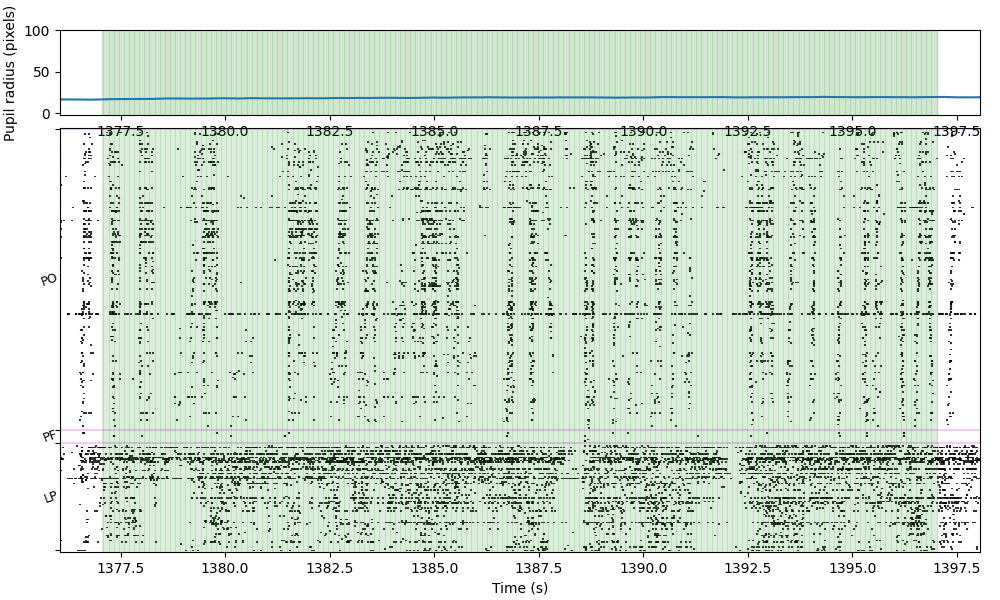

In [34]:
pdelta = 1. # plot before and after, s
pwindow = [eventrow.onset - pdelta, eventrow.offset + pdelta]
plot_regions = np.unique(THunitdf['region'].values)

fig = plt.figure(figsize=(10, 6)) # (10,10)
gs = fig.add_gridspec(ncols=1, nrows=2, left=0.06, right=0.98, top=0.95, bottom=0.08, hspace=0.05, height_ratios=[1,5])
aax = fig.add_subplot(gs[0])
rasterax = fig.add_subplot(gs[1], sharex=aax)

## Plot pupil ##
pupilinds = np.nonzero((pupilts > pwindow[0]) & (pupilts < pwindow[1]))[0]
aax.axvspan(eventrow.onset, eventrow.offset, color='g', alpha=0.05)
# aax.axhspan(awake_pupil_mean - awake_pupil_std, awake_pupil_mean + awake_pupil_std, color='b', alpha=0.05)
# aax.axhline(awake_pupil_mean, color='b', linestyle='dashed', alpha=0.2)
for si, stimi in event_stims.iterrows():
    aax.axvline(stimi.onset, color='g', linewidth=0.5, alpha=0.2)
aax.plot(pupilts[pupilinds], sm_pupil[pupilinds])
aax.set_xlim(pwindow)
aax.set_ylim([-2, 100])
# aax.set_xlabel('Time (s)')
aax.set_ylabel('Pupil radius (pixels)')

## Plot raster ##
last_ind = 0
regb = [last_ind]
for ii, pregi in enumerate(plot_regions):
    regdf = unit_info[unit_info['region'] == pregi].sort_values(by='depth', ascending=False).reset_index(drop=True)
    punitinds = range(len(regdf))
    for indi in punitinds:
        urow = regdf.iloc[indi]
        uspiketimes = all_unit_all_spikes[urow.unit_id]['spikes']
        SWDspikes = uspiketimes[
            np.nonzero((uspiketimes > pwindow[0]) & (uspiketimes < pwindow[1]))[0]
        ]
        rasterax.eventplot(SWDspikes, lineoffsets=last_ind, linelengths=1.0, color='black', alpha=0.8)
        last_ind += 1
    rasterax.annotate(
        '{}'.format(pregi), xy=(pwindow[0], last_ind - len(punitinds)/2), xycoords='data',
        annotation_clip=False, rotation=20, ha='right', va='center', fontsize=9
    )
    last_ind += 2
    regb.append(last_ind - 1)
    rasterax.axhline(last_ind - 1, color='m', alpha=0.2)
for si, stimi in event_stims.iterrows():
    rasterax.axvline(stimi.onset, color='g', linewidth=0.5, alpha=0.2)
rasterax.set_ylim(-1, last_ind)
rasterax.set_xlim(pwindow)
rasterax.set_xlabel('Time (s)')
rasterax.set_yticks(regb)
rasterax.set_yticklabels([])

### SAVE ###
# fig_name = 'spont_EEG_NPX_{:d}-{:d}s.png'.format(int(window[0]), int(window[1]))
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

### Make zoomed in rasters

In [41]:
choose_event = 2
eventrow = simple_log.iloc[choose_event]
print(eventrow)
event_stims = stim_log[stim_log['event_ID'] == choose_event]
event_stims.head()

stim_type      freq50Hz
parameter            50
duration             40
onset         1608.4194
offset       1648.41965
sweep                 0
Name: 2, dtype: object


,event_type,event_ID,stim_type,parameter,onset,offset,duration,sweep
2000,freq50Hz,2,biphasic,50,1608.41939,1608.41979,0.0004,0
2001,freq50Hz,2,biphasic,50,1608.43939,1608.43979,0.0004,0
2002,freq50Hz,2,biphasic,50,1608.45939,1608.45979,0.0004,0
2003,freq50Hz,2,biphasic,50,1608.47939,1608.47979,0.0004,0
2004,freq50Hz,2,biphasic,50,1608.49939,1608.49979,0.0004,0


Text(0.5, 1.0, 'Event 2: freq50Hz, 50$\\mu$A')

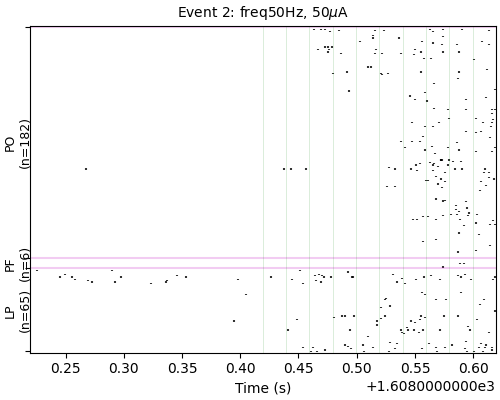

In [49]:
pdelta = [-0.2, 0.2] # plot before and after, s
pwindow = [eventrow.onset + pdelta[0], eventrow.onset + pdelta[1]]
plot_regions = np.unique(THunitdf['region'].values)

fig, rasterax = plt.subplots(figsize=(5, 4), constrained_layout=True)

## Plot raster ##
last_ind = 0
regb = [last_ind]
for ii, pregi in enumerate(plot_regions):
    regdf = unit_info[unit_info['region'] == pregi].sort_values(by='depth', ascending=False).reset_index(drop=True)
    punitinds = range(len(regdf))
    for indi in punitinds:
        urow = regdf.iloc[indi]
        uspiketimes = all_unit_all_spikes[urow.unit_id]['spikes']
        SWDspikes = uspiketimes[
            np.nonzero((uspiketimes > pwindow[0]) & (uspiketimes < pwindow[1]))[0]
        ]
        rasterax.eventplot(SWDspikes, lineoffsets=last_ind, linelengths=1.0, color='black', alpha=0.8)
        last_ind += 1
    rasterax.annotate(
        '{}\n(n={:d})'.format(pregi, len(regdf)), xy=(pwindow[0]-0.01, last_ind - len(punitinds)/2), xycoords='data',
        annotation_clip=False, rotation='vertical', ha='center', va='center', fontsize=9
    )
    last_ind += 2
    regb.append(last_ind - 1)
    rasterax.axhline(last_ind - 1, color='m', alpha=0.2)
for si, stimi in event_stims.iterrows():
    rasterax.axvline(stimi.onset, color='g', linewidth=0.5, alpha=0.2)
rasterax.set_ylim(-1, last_ind)
rasterax.set_xlim(pwindow)
rasterax.set_xlabel('Time (s)')
rasterax.set_yticks(regb)
rasterax.set_yticklabels([])
rasterax.set_title('Event {:d}: {}, {:d}$\mu$A'.format(choose_event, eventrow.stim_type, eventrow.parameter))

### SAVE ###
# fig_name = 'spont_EEG_NPX_{:d}-{:d}s.png'.format(int(window[0]), int(window[1]))
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

All events

In [22]:
len(simple_log)

25

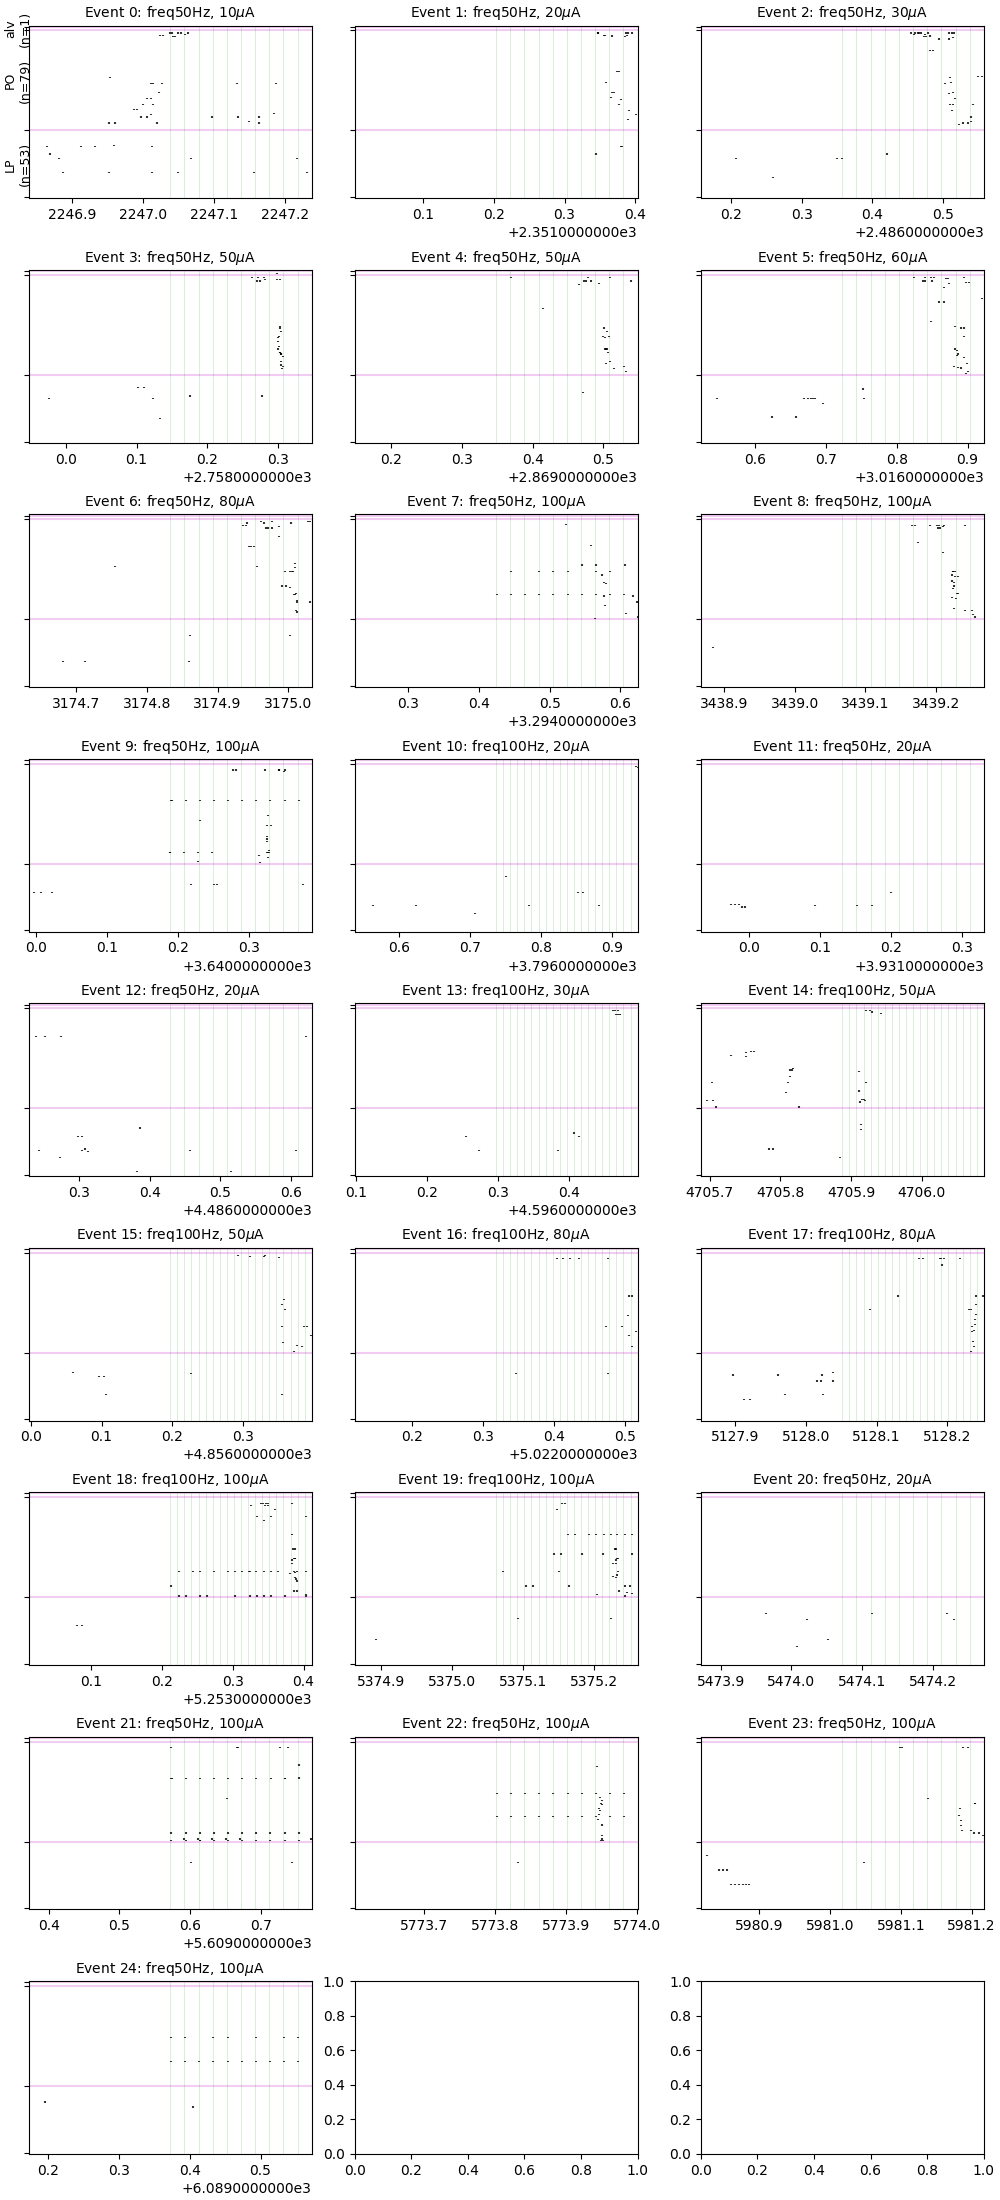

In [23]:
pdelta = [-0.2, 0.2] # plot before and after, s
plot_regions = np.unique(THunitdf['region'].values)
fig, axs = plt.subplots(9, 3, figsize=(10,22), constrained_layout=True)
for rasterax, (evind, eventrow) in zip(axs.flatten(), simple_log.iterrows()):
    pwindow = [eventrow.onset + pdelta[0], eventrow.onset + pdelta[1]]
    event_stims = stim_log[stim_log['event_ID'] == evind]
    last_ind = 0
    regb = [last_ind]
    for ii, pregi in enumerate(plot_regions):
        regdf = unit_info[unit_info['region'] == pregi].sort_values(by='depth', ascending=False).reset_index(drop=True)
        punitinds = range(len(regdf))
        for indi in punitinds:
            urow = regdf.iloc[indi]
            uspiketimes = all_unit_all_spikes[urow.unit_id]['spikes']
            SWDspikes = uspiketimes[
                np.nonzero((uspiketimes > pwindow[0]) & (uspiketimes < pwindow[1]))[0]
            ]
            rasterax.eventplot(SWDspikes, lineoffsets=last_ind, linelengths=1.0, color='black', alpha=0.8)
            last_ind += 1
        if evind == 0:
            rasterax.annotate(
                '{}\n(n={:d})'.format(pregi, len(regdf)), xy=(pwindow[0]-0.015, last_ind - len(punitinds)/2), xycoords='data',
                annotation_clip=False, rotation='vertical', ha='center', va='center', fontsize=9
            )
        last_ind += 2
        regb.append(last_ind - 1)
        rasterax.axhline(last_ind - 1, color='m', alpha=0.2)
    for si, stimi in event_stims.iterrows():
        rasterax.axvline(stimi.onset, color='g', linewidth=0.5, alpha=0.2)
    rasterax.set_ylim(-1, last_ind)
    rasterax.set_xlim(pwindow)
    # rasterax.set_xlabel('Time (s)')
    rasterax.set_yticks(regb)
    rasterax.set_yticklabels([])
    rasterax.set_title('Event {:d}: {}, {:d}$\mu$A'.format(evind, eventrow.stim_type, eventrow.parameter))

### SAVE ###
fig_name = '{}{}_THeventraster_alltrials.png'.format(exp.mouse, exp_tag)
fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

Investigate single units: raster plots and waveforms

In [40]:
print(np.unique(THunitdf['region'].values))

['LGd-co' 'LP' 'PO']


In [42]:
THnuc = THunitdf[THunitdf['region'] == 'LP']
THnuc.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region
642,E160,probeE,90,2600,0.563149,LP,294,132,161,1.718165,0.91,1.981232,0.500000,11341,TH
644,E162,probeE,92,2580,0.521943,LP,294,131,161,1.073834,0.52,0.393952,0.003268,7088,TH
645,E163,probeE,93,2580,0.576884,LP,294,131,161,2.359466,0.83,3.498602,0.500000,15574,TH
646,E164,probeE,93,2580,0.508208,LP,294,131,161,0.860067,0.85,1.919124,0.003744,5677,TH
647,E165,probeE,93,2580,0.508208,LP,294,131,161,1.278965,0.92,2.152295,0.005270,8442,TH


In [108]:
choose_event = 10
eventrow = simple_log.iloc[choose_event]
print(eventrow)
event_stims = stim_log[stim_log['event_ID'] == choose_event]
event_stims.head()

stim_type      freq50Hz
parameter            80
duration             40
onset        2904.52137
offset       2944.52159
sweep                 0
Name: 10, dtype: object


,event_type,event_ID,stim_type,parameter,onset,offset,duration,sweep
12000,freq50Hz,10,biphasic,80,2904.52137,2904.52177,0.0004,0
12001,freq50Hz,10,biphasic,80,2904.54137,2904.54177,0.0004,0
12002,freq50Hz,10,biphasic,80,2904.56137,2904.56177,0.0004,0
12003,freq50Hz,10,biphasic,80,2904.58137,2904.58177,0.0004,0
12004,freq50Hz,10,biphasic,80,2904.60137,2904.60177,0.0004,0


In [109]:
eventwindow = [eventrow.onset, eventrow.offset]
for indi, urow in THnuc.iterrows():
    uspiketimes = all_unit_all_spikes[urow.unit_id]['spikes']
    stimspikes = uspiketimes[np.nonzero((uspiketimes > eventwindow[0]) & (uspiketimes < eventwindow[1]))[0]]
    print('Unit {} ({:d}): {:d} event spikes'.format(urow.unit_id, indi, len(stimspikes)))

Unit E160 (642): 12 event spikes
Unit E162 (644): 1 event spikes
Unit E163 (645): 12 event spikes
Unit E164 (646): 9 event spikes
Unit E165 (647): 9 event spikes
Unit E166 (648): 10 event spikes
Unit E167 (649): 20 event spikes
Unit E168 (650): 9 event spikes
Unit E169 (651): 19 event spikes
Unit E170 (652): 1 event spikes
Unit E171 (653): 722 event spikes
Unit E172 (654): 7 event spikes
Unit E174 (655): 6 event spikes
Unit E175 (656): 15 event spikes
Unit E178 (657): 0 event spikes
Unit E179 (658): 5 event spikes
Unit E180 (659): 18 event spikes
Unit E182 (660): 1213 event spikes
Unit E183 (661): 13 event spikes
Unit E186 (662): 888 event spikes
Unit E187 (663): 107 event spikes
Unit E188 (664): 0 event spikes
Unit E189 (665): 0 event spikes
Unit E190 (666): 90 event spikes
Unit E191 (667): 0 event spikes
Unit E192 (668): 0 event spikes
Unit E194 (669): 0 event spikes
Unit E195 (670): 0 event spikes
Unit E196 (671): 0 event spikes
Unit E197 (672): 0 event spikes
Unit E198 (673): 4 eve

Plot a raster of an event

(0.0, 1999.0)

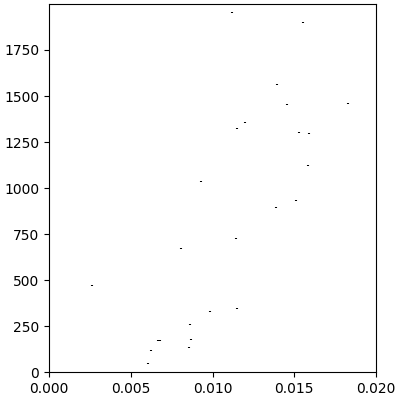

In [123]:
uind = 666
aunit = unit_info.iloc[uind]
# print(aunit)
aspiketimes = all_unit_all_spikes[aunit.unit_id]['spikes']

fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)
rasterwin = 1/int(event_stims.iloc[0].event_type[event_stims.iloc[0].event_type.find('q')+1:event_stims.iloc[0].event_type.find('Hz')])
for ei, eonset in enumerate(event_stims.onset.values):
    spikemask = (aspiketimes > eonset) & (aspiketimes < eonset + rasterwin)
    stimspikes = aspiketimes[spikemask] - eonset
    ax.eventplot(stimspikes, lineoffsets=ei, linelengths=1.5, color='black')
ax.set_xlim([0, rasterwin])
ax.set_ylim([0, ei])

Plot the mean waveform

In [114]:
probe_waveforms = np.load(exp.ephys_params[aunit.probe]['waveforms'])
print(probe_waveforms.shape)

(383, 384, 82)


Text(0.5, 1.0, 'E186 mean waveform')

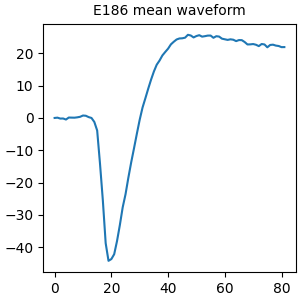

In [115]:
fig, ax = plt.subplots(figsize=(3, 3), constrained_layout=True)
ax.plot(probe_waveforms[int(aunit.unit_id[1:]), aunit.peak_ch, :])
ax.set_title('{} mean waveform'.format(aunit.unit_id))